In [2]:
from PIL import Image
import os
import glob
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import matplotlib

def imread(path):
    pil_image = Image.open(path)
    pil_image.load()
    pil_image = pil_image.convert("RGB")
    return pil_image
    
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = "cuda"

#### Select/create directories dataset list:

In [3]:
data_dir = os.path.join("log","celeba")
dataset = sorted(glob.glob(os.path.join(data_dir,'*')))
fig_path = "IMAGES"                        #save illustration figures
log_path = os.path.join("data", "zscores") #save the zscore mean and std tensors
os.makedirs(fig_path, exist_ok=True)
os.makedirs(log_path, exist_ok=True)

#### Compute z-scores for varying depths of diffusion projection:
    depth: depth of the diffusion projection (images pre-computed
    total: total number of images used in the z-score computation
    dataset: list of all the paths to the pre-computed images

    returns: mean (average)
             std (standard deviation)

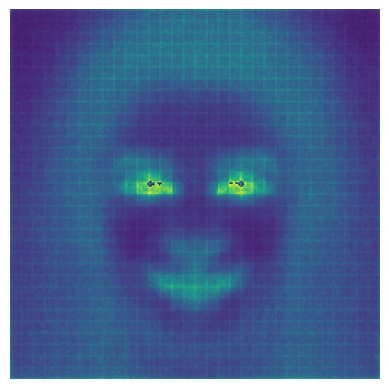

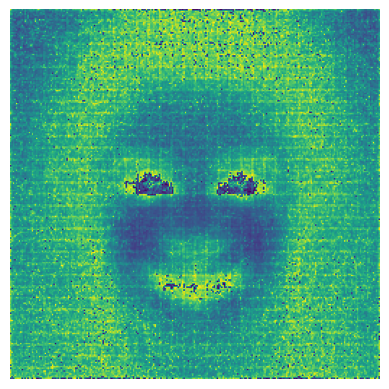

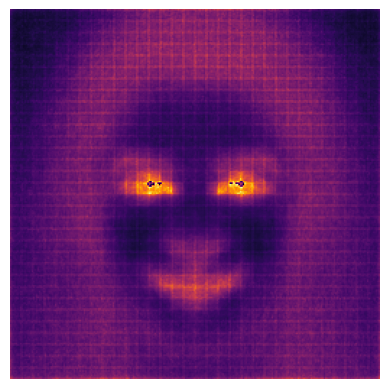

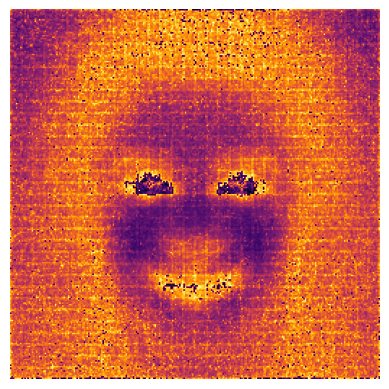

In [3]:
#############
total = 1000
depth = 100
############
for depth in [50,100,150,200,250,300,400,500,600,700]:
    mean = 0       #error mean
    mean_of_sq = 0 #mean of squares of err (for var)
    for idx in range(total):
        path = os.path.join(data_dir, f"{idx:05d}_inv{depth:04d}.png")
        path0 = os.path.join(data_dir, f"{idx:05d}.png")
        img = imread(path)
        img0 = imread(path0)
        recon_img = transforms.Compose([transforms.PILToTensor()])(img).to(device)
        clean_img = transforms.Compose([transforms.PILToTensor()])(img0).to(device)
        err = ((clean_img.to(torch.float32)-recon_img.to(torch.float32))**2)

        mean = mean + err
        mean_of_sq = mean_of_sq + err**2
        # if idx>780: #test for any potential overflow
        #     print(mean.mean().item(), mean_of_sq.mean().item(), err.mean().item(), (err**2).mean().item())
        #     print(mean.max().item(), mean_of_sq.max().item(), err.max().item(), (err**2).max().item())
        
    mean = mean / total
    mean_of_sq = mean_of_sq / total
    std = (mean_of_sq - mean**2)**0.5

    name_m = f"{data_dir.split(os.sep)[-1]}_mean_N{total}_d{depth}"
    name_s = f"{data_dir.split(os.sep)[-1]}_std_N{total}_d{depth}"
    for cmap in ['viridis', 'inferno']:
        plt.imshow(mean.mean(0).to(torch.uint8).cpu(), cmap=matplotlib.colormaps[cmap]); plt.axis("off")
        plt.savefig(os.path.join(fig_path, name_m+f"_{cmap}.png"), dpi=300, bbox_inches='tight', pad_inches=0); plt.show()
        
        plt.imshow(std.mean(0).to(torch.uint8).cpu(), cmap=matplotlib.colormaps[cmap]); plt.axis("off")
        plt.savefig(os.path.join(fig_path, name_s+f"_{cmap}.png"), dpi=300, bbox_inches='tight', pad_inches=0); plt.show()

    torch.save(mean, os.path.join(log_path, name_m))
    torch.save(std, os.path.join(log_path, name_s))

tensor cuda:0 -0.093 tensor cuda:0 30.824


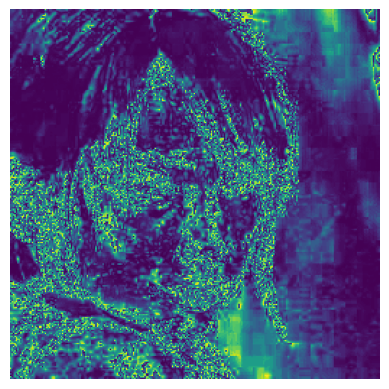

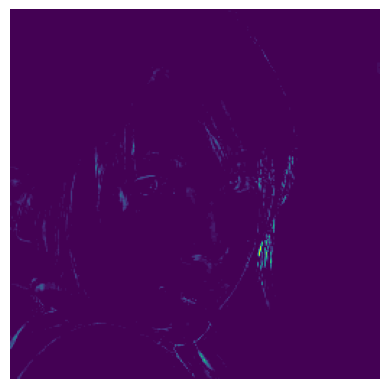

In [21]:
import lovely_tensors as lt
lt.monkey_patch()

total=1000
depth=400
name_m = f"{data_dir.split(os.sep)[-1]}_mean_N{total}_d{depth}"
name_s = f"{data_dir.split(os.sep)[-1]}_std_N{total}_d{depth}"
mean = torch.load(os.path.join(log_path, name_m))
std = torch.load(os.path.join(log_path, name_s))


for idx in [7]:
    path = os.path.join(data_dir, f"{idx:05d}_inv{depth:04d}.png")
    path0 = os.path.join(data_dir, f"{idx:05d}.png")
    img = imread(path)
    img0 = imread(path0)
    recon_img = transforms.Compose([transforms.PILToTensor()])(img).to(device)
    clean_img = transforms.Compose([transforms.PILToTensor()])(img0).to(device)
    err = ((clean_img.to(torch.float32)-recon_img.to(torch.float32))**2)

    err_z = (err - mean) / std
    print(err_z.data.mean(), err_z.data.max())
    for cmap in ['viridis']:
        plt.imshow(err.mean(0).to(torch.uint8).cpu(), cmap=matplotlib.colormaps[cmap]); plt.axis("off"); plt.show()
        plt.imshow(err_z.mean(0).to(torch.uint8).cpu(), cmap=matplotlib.colormaps[cmap]); plt.axis("off"); plt.show()


tensor[3, 256, 256] n=196608 x∈[-0.652, 18.050] μ=-0.090 σ=0.699 cuda:0


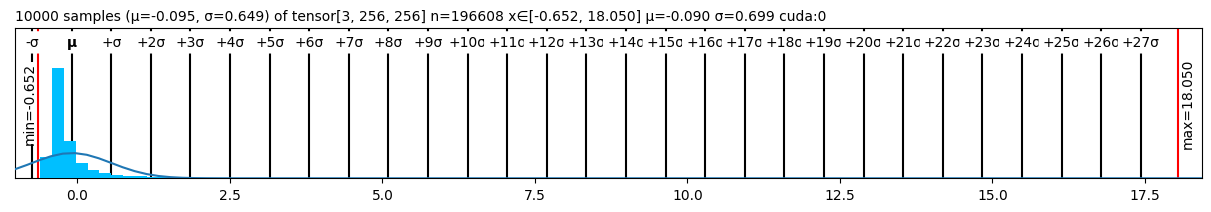

In [20]:
upper_bound = 6 #set to full hallucination above: upper_bound(in std units)
lower_bound = 1 #set to zero inpainting if under: lower_bound(in std units)
# err_z2 = err_z.clamp(lower_bound, upper_bound) - lower_bound
err_z2 = err_z
print(err_z2)
err_z2.plt(center="range")